# MNIST 2.05

This document serves as my notes on the Deep Learning Without a PhD seminar by Google. 

* [Video](https://www.youtube.com/watch?v=vq2nnJ4g6N0)
* [Slides - 1](https://docs.google.com/presentation/d/1TVixw6ItiZ8igjp6U17tcgoFrLSaHWQmMOwjlgQY9co/pub?slide=id.p)
* [Slides - 2](https://docs.google.com/presentation/d/e/2PACX-1vRouwj_3cYsmLrNNI3Uq5gv5-hYp_QFdeoan2GlxKgIZRSejozruAbVV0IMXBoPsINB7Jw92vJo2EAM/pub?slide=id.p)

This notebook covers the second example, of trying to classify MNIST digits using:

* 5 fully connected layers with a softmax.
* ReLu activation function

# Setup

## Imports

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data as mnist_data

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

## Load Data

In [2]:
# Download images and labels into mnist.test (10K images+labels) and mnist.train (60K images+labels)
mnist = mnist_data.read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


## Setup Model

In this noteboo, we're going to use 5 fully connected layers:

![](images/5-layers.png)

* take each $28 \times 28$ image, flatten into a $784$ vector
* have that fully connected to a $200$ node sigmoid layer
* have that fully connected to a $100$ node sigmoid layer
* have that fully connected to a $60$ node sigmoid layer
* have that fully connected to a $30$ node sigmoid layer
* have that fully connected to a $10$ node softmax layer - this is the classification/output layer

In this example, our intermdiate "hidden" layers are using a ReLu activation function:

![](images/relu.png)

Lets define all our sizes up front for clarity

In [3]:
batchSize = None;       # put None for right now as we dont know yet

imgHeight = 28
imgWidth = 28
numOfColors = 1         # gray scale images

flatSize = imgHeight*imgWidth*numOfColors   # 728

numberOfClasses = 10    # 10 classes: 0-9

# Size of each layer:
sizeLayerOne = 200
sizeLayerTwo = 100
sizeLayerThree = 60
sizeLayerFour = 30
sizeLayerFive = numberOfClasses       # the final layer is the output layer

Lets begin with our our input images: `X_img`:

In [4]:
# Input Data
X_img = tf.placeholder(tf.float32, [batchSize, imgHeight, imgWidth, numOfColors], name="X_img")
X_vec = tf.reshape(X_img, [-1, 784], name="X_vec")

And the necessery placeholders:

In [5]:
Y_True = tf.placeholder(tf.float32, [batchSize, 10])

Now we define our weights, biases and activations *for each layer*. 

For the first layer we are connecting a vector of size $784$ to $200$ nodes. Programatically that means connecting `flatSize` to `sizeLayerOne`:

In [6]:
with tf.name_scope("Layer_1"):
    # Weights
    W1 = tf.Variable(tf.truncated_normal([flatSize, sizeLayerOne], stddev=0.1), name="Weights")

    # Biases
    b1 = tf.Variable(tf.zeros([sizeLayerOne]), name="Biases")
    
    # Sigmoid Activation
    Y1 = tf.nn.relu(tf.matmul(X_vec, W1) + b1, name="Activation")

In [7]:
with tf.name_scope("Layer_2"):
    # Weights
    W2 = tf.Variable(tf.truncated_normal([sizeLayerOne, sizeLayerTwo], stddev=0.1), name="Weights")

    # Biases
    b2 = tf.Variable(tf.zeros([sizeLayerTwo]), name="Biases")
    
    # Sigmoid Activation
    Y2 = tf.nn.relu(tf.matmul(Y1, W2) + b2, name="Activation")

In [8]:
with tf.name_scope("Layer_3"):
    # Weights
    W3 = tf.Variable(tf.truncated_normal([sizeLayerTwo, sizeLayerThree], stddev=0.1), name="Weights")

    # Biases
    b3 = tf.Variable(tf.zeros([sizeLayerThree]), name="Biases")
    
    # Sigmoid Activation
    Y3 = tf.nn.relu(tf.matmul(Y2, W3) + b3, name="Activation")

In [9]:
with tf.name_scope("Layer_4"):
    # Weights
    W4 = tf.Variable(tf.truncated_normal([sizeLayerThree, sizeLayerFour], stddev=0.1), name="Weights")

    # Biases
    b4 = tf.Variable(tf.zeros([sizeLayerFour]), name="Biases")
    
    # Sigmoid Activation
    Y4 = tf.nn.relu(tf.matmul(Y3, W4) + b4, name="Activation")

Now we have the output layer

In [10]:
with tf.name_scope("Output_Layer"):
    # Weights
    W5 = tf.Variable(tf.truncated_normal([sizeLayerFour, sizeLayerFive], stddev=0.1), name="Weights")

    # Biases
    b5 = tf.Variable(tf.zeros([sizeLayerFive]), name="Biases")
    
    # Output logits
    Y_logits = tf.matmul(Y4, W5) + b5
    
    # Softmax Activation
    Y_Pred = tf.nn.softmax(Y_logits, name="Activation")

**Note:** The cross-entropy loss function is 

$$ - \sum \left( \tilde{Y}_i \cdot \log(Y_i) \right)$$

TensorFlow provides the `softmax_cross_entropy_with_logits` function to avoid numerical stability problems with `log(0)` which is `NaN`, so we use that instead below, *normalized for batches of $100$ images*

In [11]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Y_logits, labels=Y_True)
cross_entropy = tf.reduce_mean(cross_entropy)*100

We define our accuracy metric:

In [12]:
# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y_Pred, 1), tf.argmax(Y_True, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

And now the training step using the `Adam` Optimizer:

In [13]:
# training step, learning rate = 0.003
learning_rate = 0.003
trainStep = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

Now we can continue as before:

In [14]:
numberOfBatches = 10000
batchSize = 100

trainingAccuracyList = []
trainingLossList = []
testAccuracyList = []
testLossList = []

In [15]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    
    # actually initialize our variables
    sess.run(init)
    
    # batch-minimization loop
    for i in range(numberOfBatches):
        # get this batches data
        batch_X, batch_Y = mnist.train.next_batch(batchSize)
        
        # setup this batches input dictionary
        train_data = {X_img: batch_X, Y_True: batch_Y}
        
        # run the training step on this batch
        sess.run(trainStep, feed_dict=train_data)

        # compute this batches success on the training data
        trainAcc, trainLoss = sess.run([accuracy, cross_entropy], feed_dict=train_data)

        if i%100 == 0:
            # compute our success on the test data
            test_data = {X_img: mnist.test.images, Y_True: mnist.test.labels}
            testAcc,testLoss = sess.run([accuracy, cross_entropy], feed_dict=test_data)
            # print("Train " + str(i) + ": accuracy:" + str(trainAcc) + " loss: " + str(trainLoss))
            # print("Test " + str(i) + ": accuracy:" + str(testAcc) + " loss: " + str(testLoss))
            
            trainingAccuracyList.append(trainAcc)
            trainingLossList.append(trainLoss)
            testAccuracyList.append(testAcc)
            testLossList.append(testLoss)
            
            print("Batch number: ",i)

Batch number:  0
Batch number:  100
Batch number:  200
Batch number:  300
Batch number:  400
Batch number:  500
Batch number:  600
Batch number:  700
Batch number:  800
Batch number:  900
Batch number:  1000
Batch number:  1100
Batch number:  1200
Batch number:  1300
Batch number:  1400
Batch number:  1500
Batch number:  1600
Batch number:  1700
Batch number:  1800
Batch number:  1900
Batch number:  2000
Batch number:  2100
Batch number:  2200
Batch number:  2300
Batch number:  2400
Batch number:  2500
Batch number:  2600
Batch number:  2700
Batch number:  2800
Batch number:  2900
Batch number:  3000
Batch number:  3100
Batch number:  3200
Batch number:  3300
Batch number:  3400
Batch number:  3500
Batch number:  3600
Batch number:  3700
Batch number:  3800
Batch number:  3900
Batch number:  4000
Batch number:  4100
Batch number:  4200
Batch number:  4300
Batch number:  4400
Batch number:  4500
Batch number:  4600
Batch number:  4700
Batch number:  4800
Batch number:  4900
Batch number

# Plotting

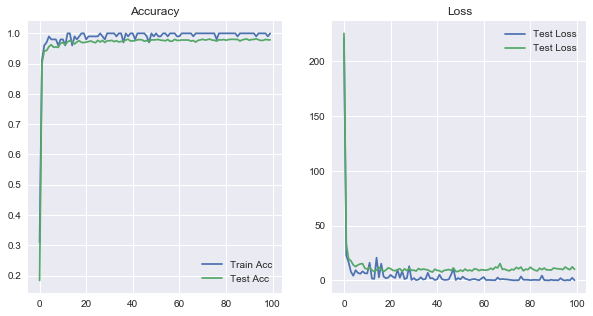

In [16]:
plt.figure(figsize=(10,5))

# Plot Accuracy
plt.subplot(1,2,1);
plt.plot(trainingAccuracyList, label="Train Acc");
plt.plot(testAccuracyList, label="Test Acc");
plt.title("Accuracy");
plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList, label="Test Loss");
plt.plot(testLossList, label="Test Loss");
plt.title("Loss");
plt.legend();

**Note:** I don't why we have that spike there! Maybe I coded up something incorrectly. Either way, lets have a look at just the tail of the plots:

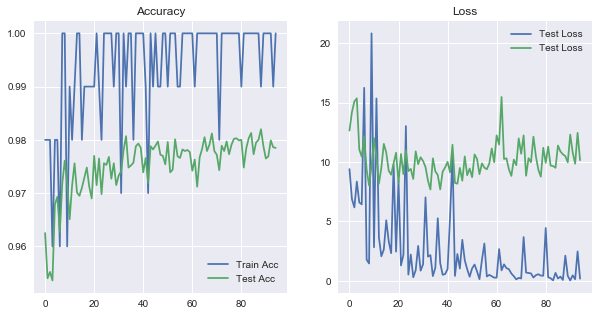

In [17]:
tailLength = -95

plt.figure(figsize=(10,5))

# Plot Accuracy
plt.subplot(1,2,1);
plt.plot(trainingAccuracyList[tailLength:], label="Train Acc");
plt.plot(testAccuracyList[tailLength:], label="Test Acc");
plt.title("Accuracy");
plt.legend();

# Plot Loss
plt.subplot(1,2,2);
plt.plot(trainingLossList[tailLength:], label="Test Loss");
plt.plot(testLossList[tailLength:], label="Test Loss");
plt.title("Loss");
plt.legend();

# Note

In this example, I originally ran initialized my variables using:

```
tf.truncated_normal([flatSize, sizeLayerOne])
```

**without** specifying a `stddev=0.1` as done in the video, and I was getting the following results, even after $20,000$ iterations:

![](images/2.05-relu-no-std-1.png)

![](images/2.05-relu-no-std-2.png)

only after specifying the `stddev=0.1` did I get the desired results. From the documentation:

```
The generated values follow a normal distribution with specified mean and standard deviation, except that values whose magnitude is more than 2 standard deviations from the mean are dropped and re-picked.
```

`stddev` has a default value of $1$ which was causing the problem